### Compare CONUS2 and USGS streamflow ###
DTT, 10/22

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and creates comparison hydrographs. Gages have been matched between the two csv's to make sure that we're comparing viable gage locations in `1_Organize_Streamflow.ipynb`. 

Inputs:
- CONUS2 daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb`
- USGS daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb` 
- USGS gage metadata csv, ouput from `1_Organize_Streamflow.ipynb` 

Outputs:
- Hydrographs of USGS and CONUS2 flow

Notes:
- as of 11/22 there are no stats included in these hydrographs. Need to either add a calculation here or pull from the SaveStreamflowStats.ipynb and add these to the plots

In [1]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd

In [2]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'


# Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/'
print(f'Figures saving to: {plot_dir}')


# names of csv files
usgs_csv = 'USGS_Daily_matched_flow_cms_2003.csv'
pf_csv = 'PFCONUS2_Daily_matched_flow_cms_2003.csv'
metadata_csv = 'USGS_metadata_matched_flow_2003.csv'
stats_csv = 'Summary_Gages_CONUS2_WY2003.csv'

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow/


In [3]:
from PIL import Image

# Read in CONUS2 mask for map plot border
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
#CONUS2_mask = Image.open('/home/dtt2/CONUS2/shape_files/CONUS2_HUC2_boundaries_clipped.tif')
mask_array = np.array(CONUS2_mask)

### Read in files
Read in PF flow, USGS flow, USGS metadata, and calculated stats from `SaveStreamflowStats.ipynb`

In [4]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,43.948426,40.765870,34.389042,27.512755,22.526485,18.593126,15.312236,12.532960,10.260977,8.550327,...,0.228571,0.168567,0.238709,0.472419,0.646194,0.612115,0.546623,0.822631,8.067395,0.0
1010070,5.335298,3.581117,2.112628,1.401444,1.006803,0.803474,0.716559,0.526913,0.385837,0.335107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116555,2.476887,0.0
1010500,94.018137,87.844915,81.101017,74.425605,67.642209,60.635444,52.793281,44.862003,38.017604,32.625893,...,1.563807,1.286330,1.151007,1.301772,1.288099,1.414516,1.376162,1.649360,44.722650,0.0
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.383030,0.248542,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.542694,0.269608,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0


In [5]:
### read in USGS daily flow matched csv
usgsdata = pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id']) 
usgsdata.head()
# # change zero values in USGS df so that we can calculate stats without errors
# usgsdata = usgsdata.where(usgsdata>0, 0.0001)

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,9.16920,7.83910,7.72590,6.79200,5.77320,5.12230,4.72610,4.47140,4.13180,3.93370,...,4.07520,3.99030,3.99030,4.38650,6.39580,7.07500,6.84860,7.47120,8.97110,9.19750
1010070,0.59713,0.50657,0.45846,0.43582,0.42733,0.39054,0.37922,0.36224,0.37073,0.39903,...,0.94805,0.89994,0.90277,1.03578,1.35274,1.42066,1.39236,1.33576,1.64423,1.52254
1010500,8.32020,11.46150,12.93310,11.37660,11.40490,10.30120,9.28240,8.20700,7.52780,7.44290,...,11.60300,11.40490,11.12190,11.91430,13.15950,13.95190,15.90460,18.05540,58.58100,74.14600
1011000,7.41460,7.38630,6.99010,6.56560,6.36750,6.19770,5.74490,5.06570,4.52800,4.41480,...,12.65010,12.36710,11.94260,12.70670,13.69720,13.61230,13.15950,14.00850,66.22200,76.12700
1013500,3.50920,3.42430,3.16960,3.11300,3.33940,2.85830,2.85830,2.63190,2.40550,2.50455,...,14.37640,13.81040,13.61230,13.55570,13.15950,12.25390,11.94260,15.76310,58.29800,51.22300


In [6]:
### read in USGS streamflow gage metadata for all gages with flow in October
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])#, 
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#usgs_all_gages = usgs_all_gages.transpose() #transpose df for easier plotting
usgs_gage_metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,stream gauge,USGS,"St. John River at Ninemile Bridge, Maine",1010000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,46.700556,-69.715556,ME,1010001,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1341.0,1341.0,Y,NaN,442300100,365
1010070,stream gauge,USGS,"Big Black River near Depot Mtn, Maine",1010070,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,46.893889,-69.751667,ME,1010001,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,171.0,171.0,Y,NaN,442300100,365
1010500,stream gauge,USGS,"St. John River at Dickey, Maine",1010500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.113056,-69.088056,ME,1010001,...,NaN,YNNNYNNNNYNNNYNNYNNNNNNNNNNNNN,NaN,NaN,2680.0,2680.0,Y,NaN,442300100,365
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.069722,-69.079444,ME,1010002,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.0,1229.0,Y,NaN,442300100,365
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.237500,-68.582778,ME,1010003,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.0,873.0,Y,NaN,442300100,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,stream gauge,USGS,"APPLEGATE RIVER NEAR APPLEGATE, OR",14366000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.241511,-123.140049,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,483.0,NaN,Y,C,NaN,365
14369500,stream gauge,USGS,"APPLEGATE RIVER NEAR WILDERVILLE, OR",14369500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.354006,-123.406728,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,698.0,NaN,Y,C,NaN,365
14372300,stream gauge,USGS,"ROGUE RIVER NEAR AGNESS, OR",14372300,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.578442,-124.058144,OR,17100310,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,3939.0,NaN,Y,C,NaN,365


In [7]:
usgs_gage_metadata.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'date_metadata_last_updated', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'doi', 'observation_id', 'site_id:1', 'var_id',
       'start_date_listed', 'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'conus1_x', 'conus1_y', 'conus1_latitude', 'conus1_longitude',
       'conus1_moved', 'conus1_parflow_drainage_area', 'conus2_x', 'conus2_y',
       'conus2_latitude', 'conus2_longitude', 'conus2_moved',
       'conus2_parflow_drainage_area', 'gages_drainage_sqkm', 'bound_source',
       'class', 'aggecoregion', 'hydro_disturb_indx', 'wr_report_remarks',
       'adr_citation', 'screening_comments', 'basin_compactness',
       'basin_elevation_mean_meters', 'basin_elevation_max_meters',
       'basin_elevation_min_meters', 'basin_elevation_medi

In [8]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{stats_csv}',index_col=['site_id']) 
stats_df

,latitude,longitude,conus2_x,conus2_y,huc,HUC2,USGS_mean_cms,PF_mean_cms,pf_minus_obs,absrelbias,bias,pbias,srho,r2,rmse,mse
site_id,,,,,,,,,,,,,,,,
1010000,46.700556,-69.715556,4181,2731,1010001,1,54.732510,21.812227,-12015.903320,0.601476,-0.601476,-60.147585,0.859089,0.194915,77.527725,6010.548221
1010070,46.893889,-69.751667,4172,2746,1010001,1,9.014225,2.360176,-2428.727876,0.738172,-0.738172,-73.817209,0.697101,0.161414,14.367161,206.415312
1010500,47.113056,-69.088056,4209,2784,1010001,1,104.191141,51.536925,-19218.788658,0.505362,-0.505362,-50.536173,0.795350,0.387808,126.564636,16018.606962
1011000,47.069722,-69.079444,4210,2783,1010002,1,41.836549,29.714315,-4424.615543,0.289752,-0.289752,-28.975225,0.706543,0.598717,36.749715,1350.541531
1013500,47.237500,-68.582778,4237,2810,1010003,1,39.405556,18.607378,-7591.334817,0.527798,-0.527798,-52.779810,0.517411,0.220357,44.114798,1946.115399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,42.241511,-123.140049,160,2249,17100309,17,18.873852,25.896216,2563.163016,0.372068,0.372068,37.206844,0.632911,-3.375751,45.213866,2044.293688
14369500,42.354006,-123.406728,144,2268,17100309,17,23.789678,36.039689,4471.254207,0.514930,0.514930,51.492969,0.764957,-2.476956,58.971814,3477.674854
14372300,42.578442,-124.058144,106,2303,17100310,17,158.010142,208.546605,18445.808844,0.319830,0.319830,31.983050,0.769574,-0.612741,233.161133,54364.113719


## Plot streamflow by region / HUC2

In [9]:
usgs_gage_metadata['HUC2'] = usgs_gage_metadata['huc'] // 1000000 #get the HUC2 while preserving the dtype=int64
stats_df['HUC2'] = usgs_gage_metadata['HUC2']

Text(0.5, 1.0, 'PF-CONUS2 Streamflow gages by HUC2 WY2003')

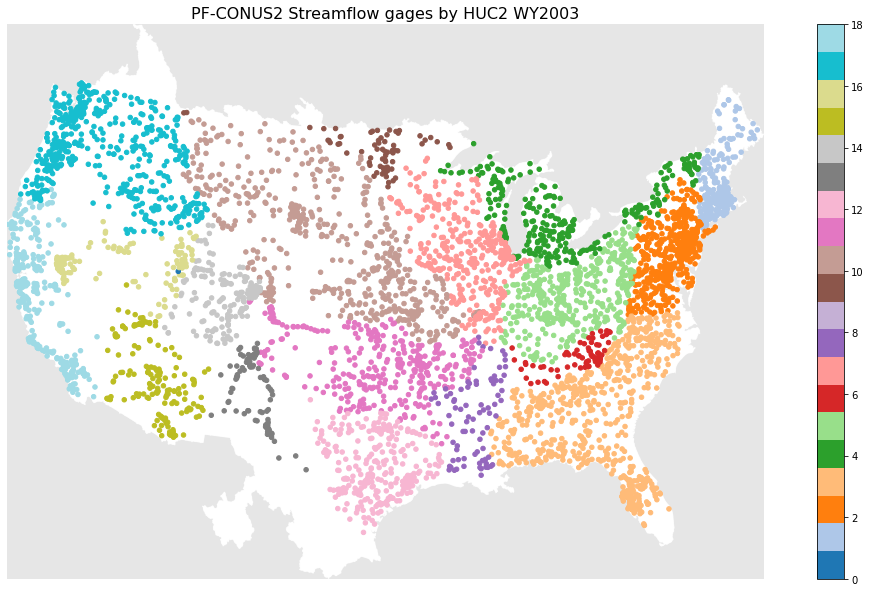

In [10]:
fig = plt.figure(figsize=(19,10), dpi=72)
plt.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
plt.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.HUC2, s=20, cmap = 'tab20')
plt.colorbar()
plt.axis('off')
plt.title(f'PF-CONUS2 Streamflow gages by HUC2 WY{water_year}', fontsize = 16)
# plt.savefig(f'{plot_dir}/PFCONUS2_Srho_Map_WY{water_year}.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [11]:
import sys
#sys.path.insert(1,'/home/ym5379/.conda/envs/rapids-22.02/lib/python3.9/site-packages') #To use the gdal package
import xarray
import numpy as np
import pandas as pd
from pyproj import Proj, transform, CRS
from PIL import Image
from osgeo import gdal
from imagecodecs import imread

from parflow.tools.io import read_pfb, write_pfb

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib

import tifffile

import rioxarray

from mpl_toolkits.basemap import Basemap

In [12]:
#CONUS2 coordinates 
lats_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Latitude_CONUS2.pfb'),axis=0)
lons_CONUS2 = np.squeeze(read_pfb('/hydrodata/national_mapping/CONUS2/Longitude_CONUS2.pfb'),axis=0)

file = '/hydrodata/national_mapping/CONUS2/CONUS2.0.Final1km.Subbasin_HUC2.remapped.tif'

# open HUC2 tiff and make into numpy array
im = Image.open(file) 
imarray = np.array(im) 
print(imarray.shape)
tiff_numpy = np.flipud(imarray)

(3256, 4442)


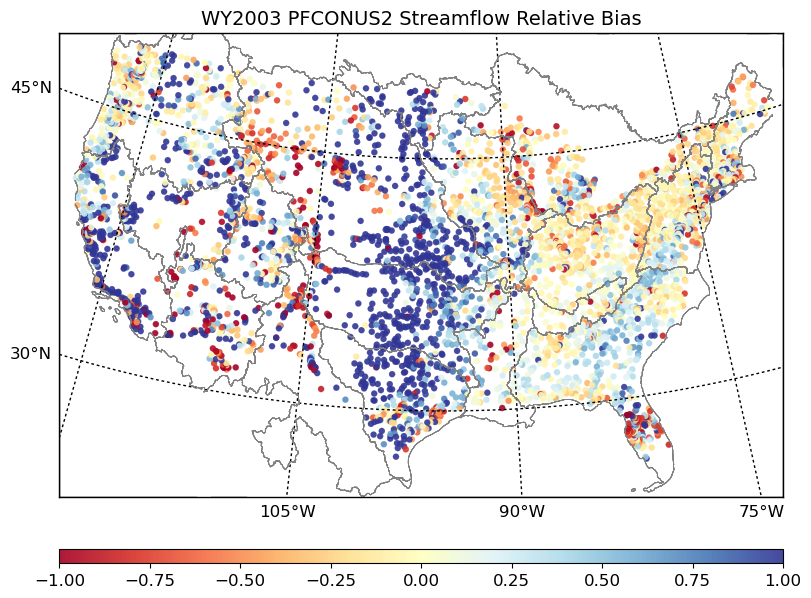

In [13]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)

m1 = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=33,lat_2=45,lon_0=-95,ax=ax1)


#Well coordinates
lons1, lats1 = m1(stats_df.longitude,stats_df.latitude)

lons_basin, lats_basin = m1(lons_CONUS2,lats_CONUS2)

#Draw coastlines & countries
#m1.drawcoastlines(color='k',linewidth=0.8)
#m1.drawcountries(color='k',linewidth=0.8)

#Draw parallels and meridians
m1.drawparallels(np.arange(-90.,91.,15.),labels=[True,False,False,False],dashes=[2,2],fontsize=12)
m1.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2],fontsize=12)

m1.fillcontinents(color='white',lake_color='white')
m1.drawmapboundary(fill_color='white')

im1 = m1.scatter(lons1,lats1,c=stats_df['bias'],s=20,linewidths=0.1,cmap='RdYlBu',alpha=.9,vmin = -1, vmax = 1)#,vmax=100

ax1.set_title(f'WY{water_year} PFCONUS2 Streamflow Relative Bias',fontsize=14) 

cbar1 = plt.colorbar(im1,ax=ax1,shrink=1,aspect=50,orientation='horizontal')
cbar1.ax.tick_params(labelsize=12)

#Draw river basins
for water_basin_index in range(1,19):
    mask_index = np.where(tiff_numpy==water_basin_index)
    mask_arr = np.zeros([tiff_numpy.shape[0],tiff_numpy.shape[1]])
    mask_arr[mask_index] = 1
    
    m1.contour(lons_basin,lats_basin,mask_arr,colors='grey',linewidths=0.5)

plt.savefig(f'{plot_dir}/PFCONUS2_RelBias_Map_WY{water_year}_HUC2boundaries.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

plt.show()

In [14]:
huc_2_names = {1:'New England', 2:'Mid-Atlantic', 3:'South Atlantic-Gulf', 4:'Great Lakes',
              5:'Ohio', 6:'Tennessee', 7:'Upper Miss', 8:'Lower Miss', 9:'Souris-Red-Rainy',
              10: 'Missouri', 11: 'Ar-White-Red', 12: 'Texas', 13: 'Rio Grande', 
              14: 'Upper CO', 15: 'Lower CO', 16: 'Great Basin', 17: 'Pacific Northwest',
              18: 'California'}

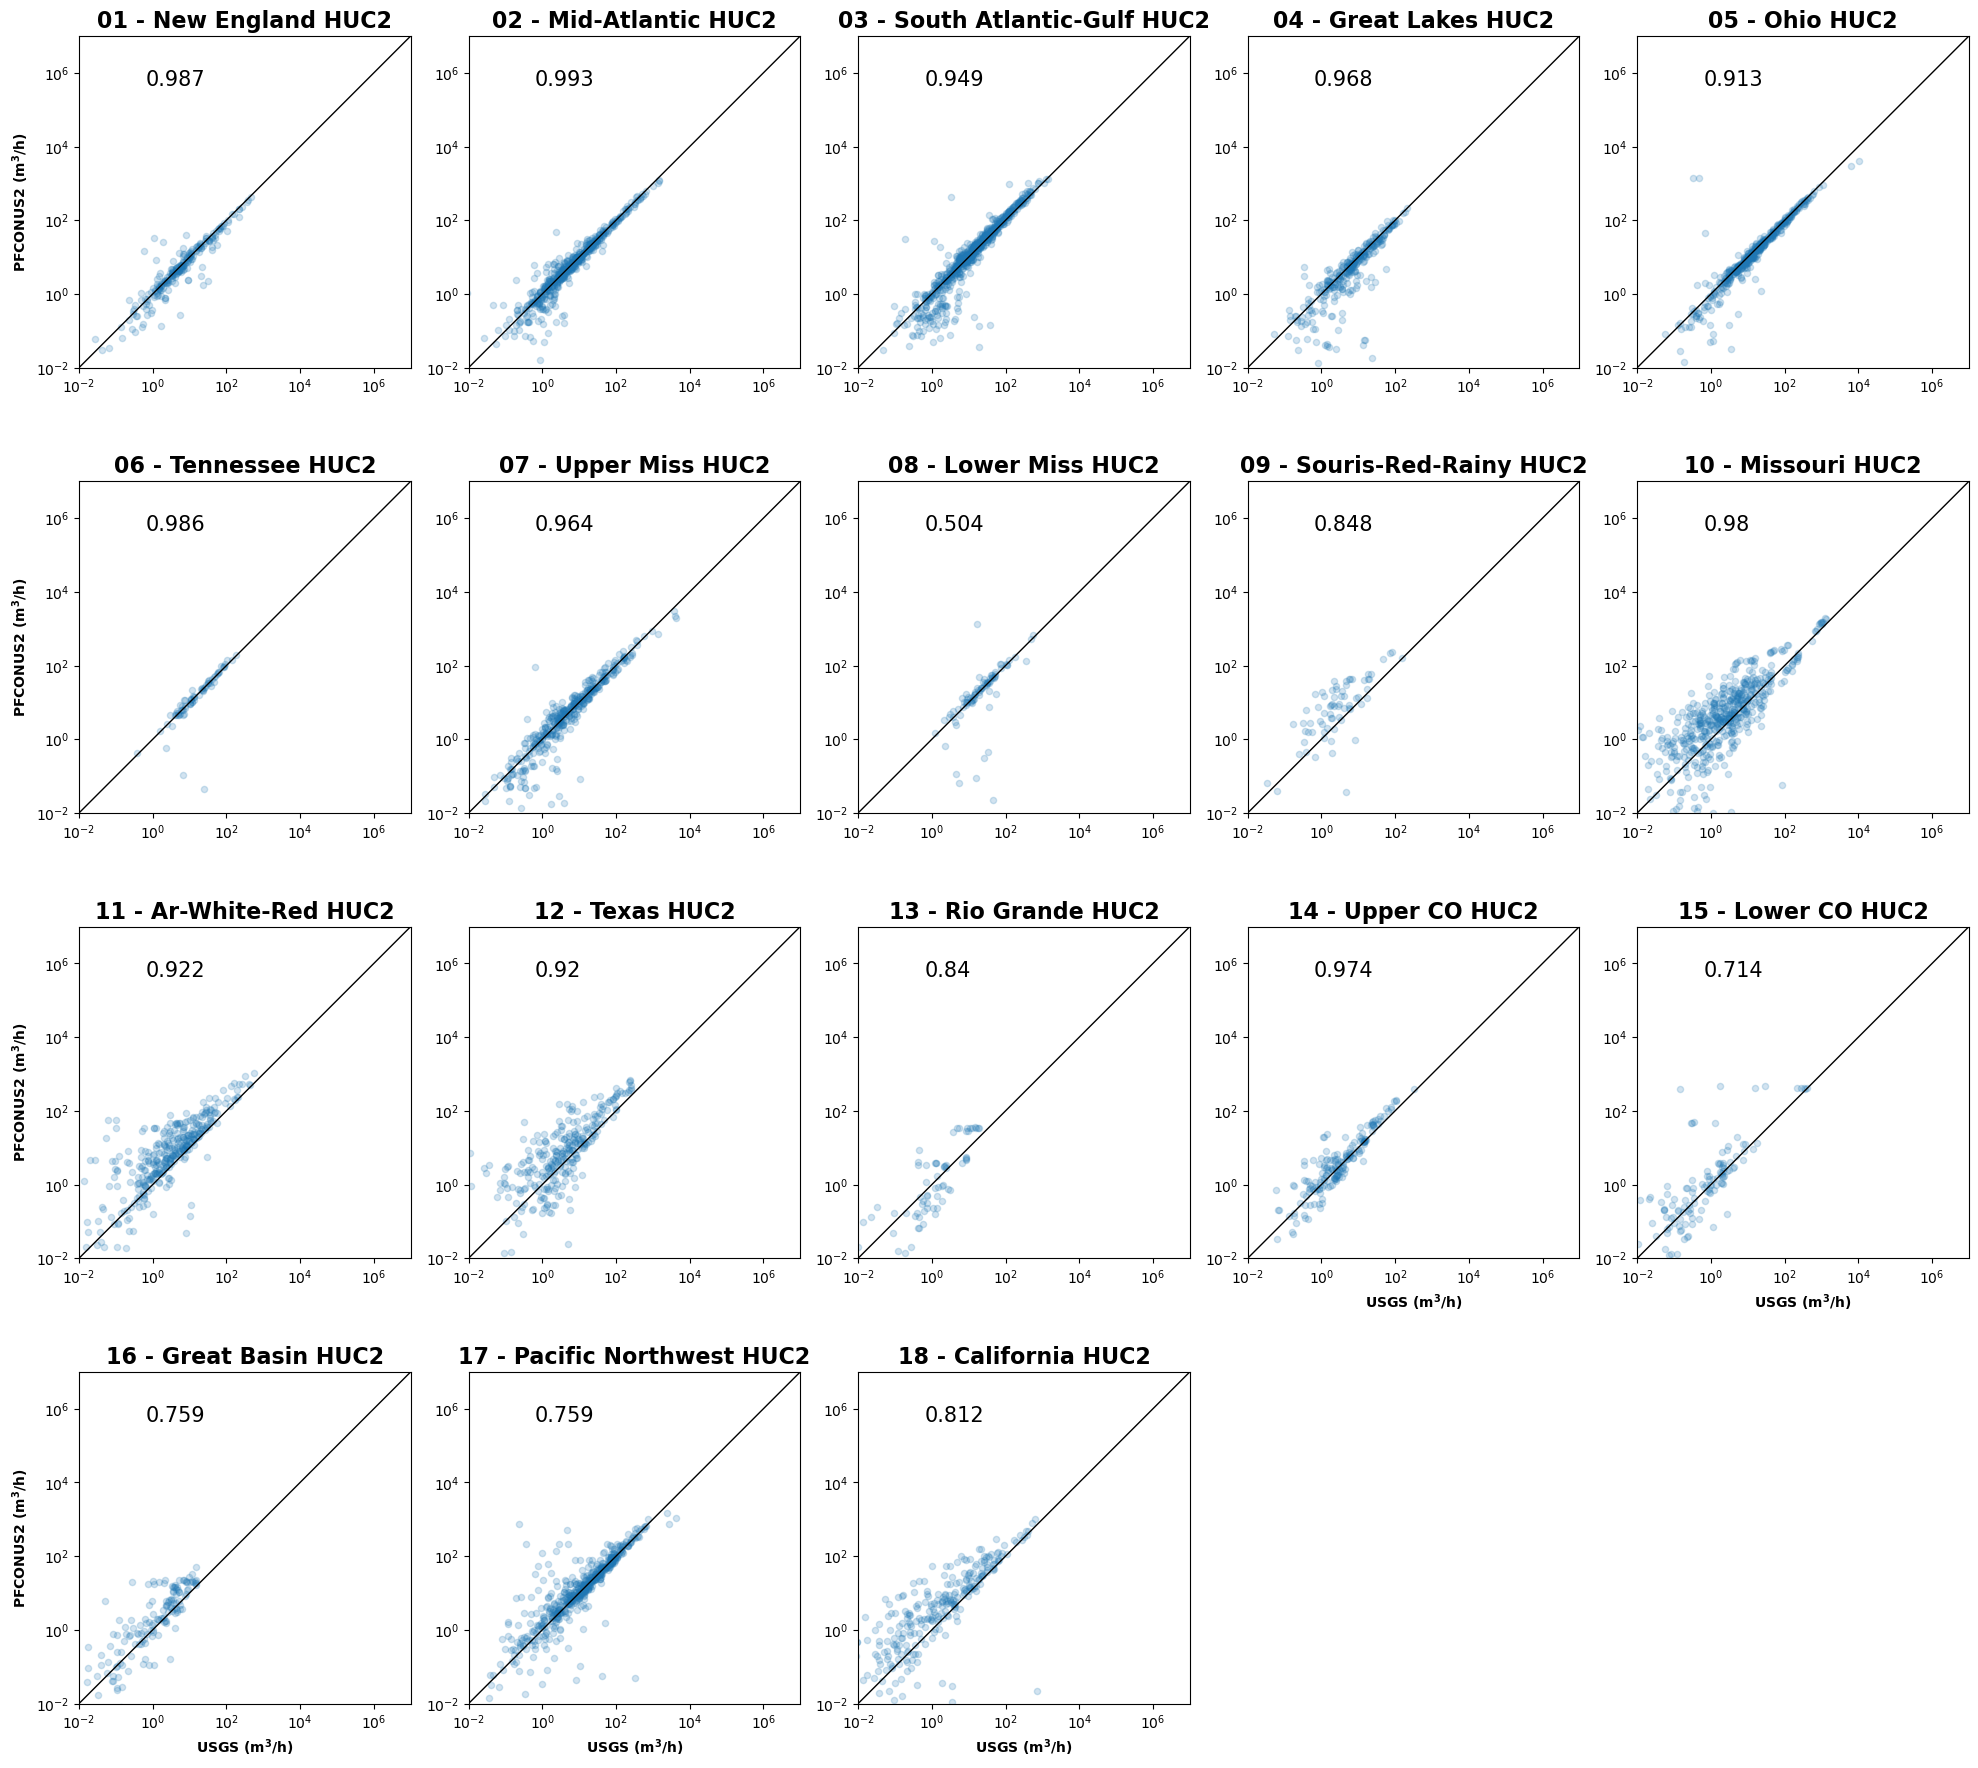

In [16]:
ncol = 5
fig, axs = plt.subplots((18 // ncol)+1, ncol, figsize=(20,18))

for ii in range(18):
    ax = axs[ii//ncol, ii%ncol]
    tmp_obs = stats_df.loc[stats_df['HUC2']==ii+1,'USGS_mean_cms']
    tmp_sim = stats_df.loc[stats_df['HUC2']==ii+1,'PF_mean_cms']
    tmp_corr = np.corrcoef(tmp_obs,tmp_sim)[0,1]
    ax.plot(range(0,10000000,100000),range(0,10000000,100000),'k',linewidth = 1)
    ax.scatter(tmp_obs, tmp_sim,s=20, alpha=0.2)
    ax.text(0.2,0.85,str(np.round(tmp_corr,3)),fontsize=15, transform=ax.transAxes)
    ax.set_ylim(1e-2,1e7)
    ax.set_xlim(1e-2,1e7)
    if(ii > 12):
        ax.set_xlabel('USGS ($\mathregular{m^3}$/h)', fontsize=10, fontweight='bold')
    #else:
        #ax.tick_params(axis='both', labelbottom=False)
    if(ii%ncol == 0):
        ax.set_ylabel('PFCONUS2 ($\mathregular{m^3}$/h)', fontsize=10, fontweight='bold')
    #else:
        #ax.tick_params(axis='both', labelleft=False) 
    ax.set_title(str(int(ii+1)).rjust(2, '0') + f' - {huc_2_names[ii+1]} HUC2', fontsize=16, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(adjustable='box', aspect='equal')
plt.tight_layout()
fig.delaxes(axs[3][3])
fig.delaxes(axs[3][4])
plt.savefig(f'{plot_dir}/HUC2region_MeanAnnualStreamflow_Scatter_PFCONUS2_WY{water_year}.png', dpi=300)

## Drainage area plots

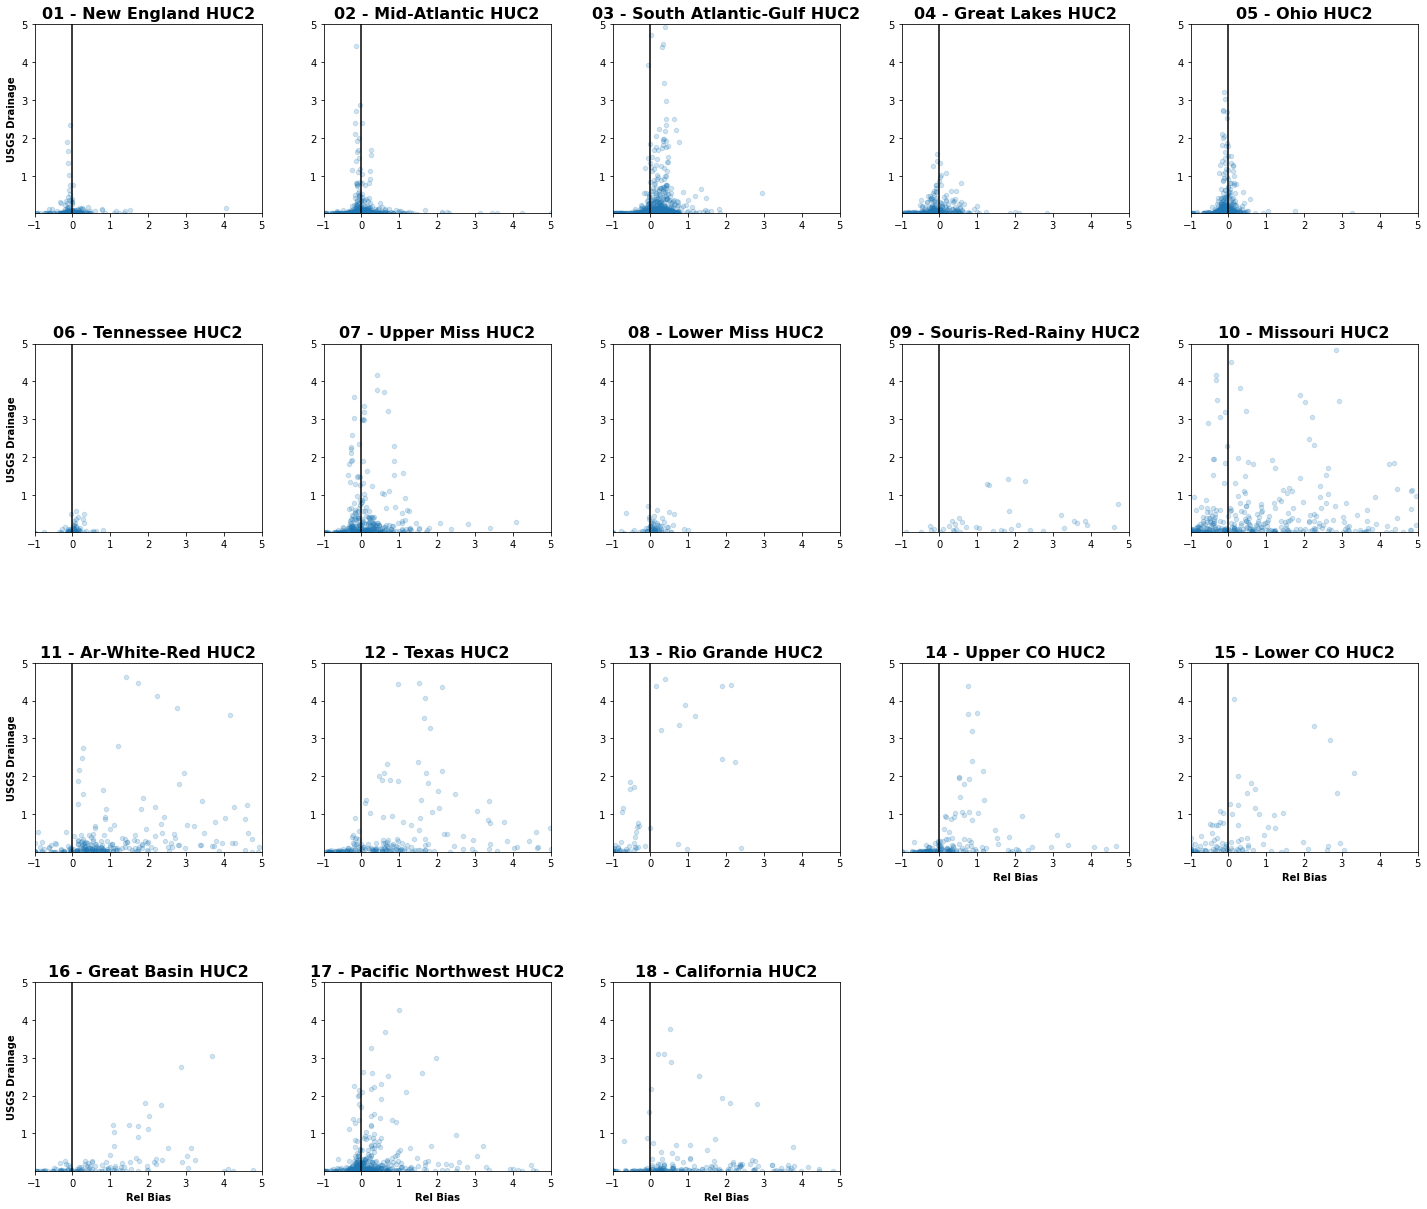

In [94]:
# Specify which drainage you are using
drainage_col = 'conus2_parflow_drainage_area'#'gages_drainage_sqkm'#'contrib_drain_area_va'#'drain_area_va' ##

# set up figure
ncol = 5
fig, axs = plt.subplots((18 // ncol)+1, ncol, figsize=(20,18))

for ii in range(18):
    ax = axs[ii//ncol, ii%ncol]
    tmp_obs = stats_df.loc[stats_df['HUC2']==ii+1,'bias'] 
    tmp_sim = usgs_gage_metadata.loc[usgs_gage_metadata['HUC2']==ii+1, drainage_col]/10000 
    ax.axvline(x=0, color = 'k')
    ax.scatter(tmp_obs, tmp_sim,s=20, alpha=0.2)
    ax.set_ylim(1e-2,5)
    ax.set_xlim(-1,5)
    if(ii > 12):
        ax.set_xlabel('Rel Bias', fontsize=10, fontweight='bold')
    #else:
        #ax.tick_params(axis='both', labelbottom=False)
    if(ii%ncol == 0):
        ax.set_ylabel('USGS Drainage', fontsize=10, fontweight='bold')
    #else:
        #ax.tick_params(axis='both', labelleft=False) 
    ax.set_title(str(int(ii+1)).rjust(2, '0') + f' - {huc_2_names[ii+1]} HUC2', fontsize=16, fontweight='bold')
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set(adjustable='box', aspect='equal')
plt.tight_layout()
fig.delaxes(axs[3][3])
fig.delaxes(axs[3][4])
plt.savefig(f'{plot_dir}/HUC2region_RelBiasVS{drainage_col}_Scatter_PFCONUS2_WY{water_year}.png', dpi=300)

In [103]:
huc_num = 18 # HUC2 to plot
huc2_bias = stats_df.loc[stats_df['HUC2']==huc_num,'bias'] 
huc2_bias = huc2_bias.loc[huc2_bias<1000]
huc2_plt_metadata = usgs_gage_metadata[usgs_gage_metadata.index.isin(huc2_bias.index)]
huc2_drain = huc2_plt_metadata[drainage_col]#/10000

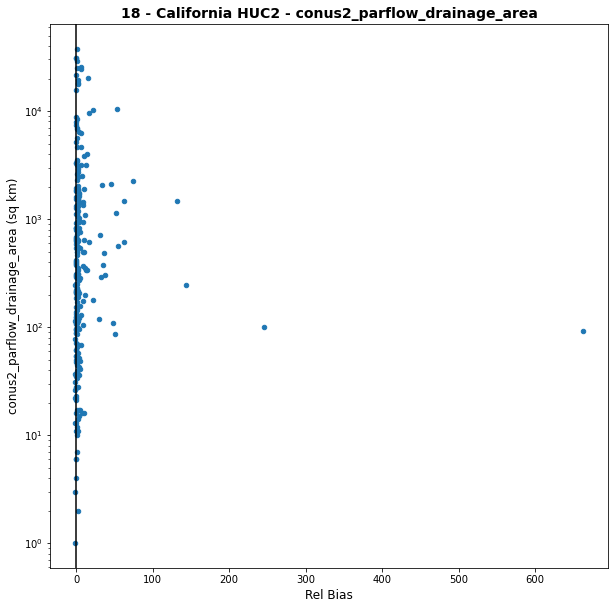

In [104]:
fig = plt.figure(figsize=(10,10), dpi=72)
plt.scatter(huc2_bias, huc2_drain, cmap='tab20', s=20)
plt.axvline(x=0, color = 'k')
#plt.xlim(-1.3,10)
plt.title(str(int(huc_num)).rjust(2, '0') + f' - {huc_2_names[huc_num]} HUC2 - {drainage_col}', fontsize=14, fontweight='bold')
plt.xlabel('Rel Bias', fontsize=12)
plt.ylabel(f'{drainage_col} (sq km)', fontsize=12)
plt.yscale('log')
plt.savefig(f'{plot_dir}/RelBiasVS{drainage_col}_Scatter_{huc_2_names[huc_num]}_PFCONUS2_WY{water_year}.png', dpi=300)

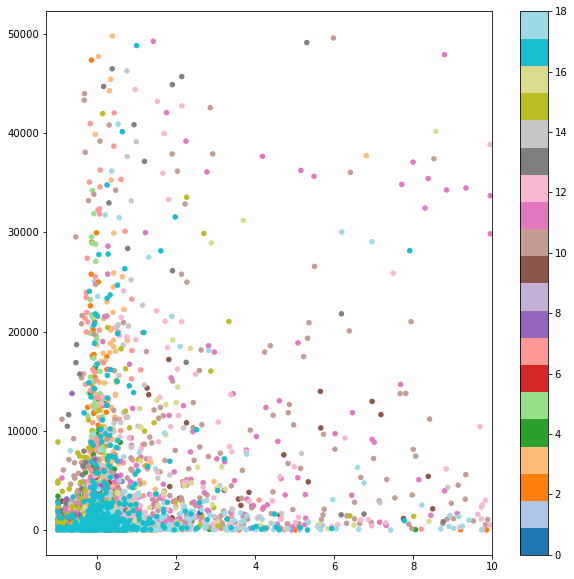

In [78]:
fig = plt.figure(figsize=(10,10), dpi=72)
plt.scatter(stats_df.bias,usgs_gage_metadata.gages_drainage_sqkm, c=stats_df.HUC2, cmap='tab20', s=20)
plt.xlim(-1.3,10)
plt.colorbar()
#plt.yscale('log')

In [155]:
stats_df.bias.min()

-1.0